![DLI Logo](../assets/DLI_Header.png)

In [1]:
%%html
<video controls src="https://d36m44n9vdbmda.cloudfront.net/assets/s-ds-03-v1/videos/inversion.mp4" 
width=800>inversion</video>

# Inversion

Inversion is the process of inverting a model in order to get a representation of the training data. Sometimes this is a 1:1 match for what the training data is, however, that is rare. It's best to imagine a model as a lossy compression algorithm. It contains a portion of the training data that it was trained on, however the trick is figuring out how to extract it and in practice, this is actually quite a difficult attack to execute. Not only does it take a ton of queries, but you never _actually_ get training data - only a representation of it... at least for images. This attack is not implausible by any means, as we show you in the LLM labs, but what you'll see in this lab is an ideal situation and you should expect attacks against real production models to be even less precise.

## Learning Objectives

1. How to perform a basic inversion attack by finding an input that maximizes a particular output.
2. How to build a custom loss function that uses domain specific knowledge to improve the simple inversion attack.
3. How to use AIRT tools to automate inversion attacks against models.
4. Attack a more realistic model and see where the basic attacks begin to fail, and how to explore parameterization of the attack to improve it.
5. An example of extracting data from diffusion models.


# Imports and Model
we're going to begin with a very simple "toy" MNIST model.

In [1]:
# DO NOT CHANGE

import random
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from IPython import display
from matplotlib import pyplot as plt
from art.estimators.classification import PyTorchClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace
from diffusers import StableDiffusionPipeline

from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

:::{warning} If you see a warning such as `WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions.` it won't affect the lab, so it can be safely ignored.
:::

In [3]:
# DO NOT CHANGE

class MNIST_CNN_model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
        )
        self.dropout = nn.Dropout(.5)
        self.dense0 = nn.Linear(6272, 10)
        
    def forward(self, x):
        h = self.convs(x)
        
        h = torch.flatten(h, 1)
        h = self.dropout(h)
        h = self.dense0(h)
        return h

We (re)define our model in order to have a structure to load the weights into.

Things to notice:
1. We use the `nn.Sequential` class to define a series of layers to be applied in sequence (`self.convs`). This can make model definition much cleaner and easier, particularly if you're moving to PyTorch from Keras. We can apply the entire sequence in `.forward()` by calling it as if it were its own layer.
2. We use two convolutional layers as we examined earlier
3. We have a single max pooling layer; this helps shrink the size of the representation as well as allow the model to generalize better across spatial locations.  You can read more about pooling layers [here](https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/) if you're interested, but you don't need to know how they work to attack them.

And now we load the weights into our model and move it to the correct device. Models are a combination of imperative code (defined above) and the parameters that that code uses.  The PyTorch `state_dict` produces a dictionary where keys are parameter names, and values are the values of those parameters.  These can be inspected for a model via `model.state_dict()` and loaded into a model (with checks to make sure that the keys match between the model and the dictionary being loaded) via `model.load_state_dict()`.

In [4]:
# DO NOT CHANGE

# define a randomly initialized model to have somewhere to put the weights
model = MNIST_CNN_model()

# torch.load loads the dictionary from file; we tell the model that the weights should be placed onto the cpu initially (otherwise
# the device they were on when saved will be used by default)
model.load_state_dict(torch.load("mnist_model.pt", map_location='cpu'))
# set the model into eval mode
model.eval()
# ... and move it to the correct device
model.to(device)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_22160\891686185.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mnist_model.pt", map_loca

MNIST_CNN_model(
  (convs): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (dense0): Linear(in_features=6272, out_features=10, bias=True)
)

## A Manual Inversion Attack

The MIFace attack was originally developed for facial recognition systems, where an image of a person that the classifier was trained on could be recovered.  In practice, this works best for models (like facial recognition) where the examples for each class look *very* similar to each other.  In ML terms, model inversion works best when the model is 'overfit' to a particular class, meaning it has effectively memorized it.

The general method of attack for all these issues is the same, and should be a bit reminiscent of generating an adversarial example.  If we think that the model is overfit on a specific image, then it should respond with a very strong classification for that input. If we hunt through the space of images to find one that elicits a strong response from the model, then there's a good chance that maps to a training image.

As before, we're going to search through the space of images by: 
1. starting with an "average" image: a value of 0.5 in all pixels
2. using the magic of stochastic gradient descent to optimize that image (rather than model weights) to generate the image that *most* activates the target class, while keeping the value in the acceptable range of 0-1 for each pixel (using `torch.clamp`).
3. there is no step 3.


There are more complex variations on this that can be performed -- for instance you can try to penalize the image for not being "smooth", or for having too many non-zero pixels (if you know that the source images should be mostly black), and so on.  We'll explore one of those in a moment.

:::{admonition} Exercise!

Step through the code below. Make sure you understand it. Try a different optimizer as well as a range of learning rates. Try different classes. 

Do you ever get two different images for the same class on two different runs?
:::

In [4]:
# provided code

x = nn.Parameter(torch.ones(1,1,28,28)*.5)
x_optimizer = torch.optim.Adam([x]) # change this (some code in the torch lab might be helpful here

target = torch.tensor([0])

In [8]:
# DO NOT CHANGE

for step in range(1_000):
    yhat = model(x.to(device))
    x_optimizer.zero_grad()
    loss = F.cross_entropy(yhat, target.to(device))
    loss.backward()
    x_optimizer.step()
    x.data = torch.clamp_(x.data, 0, 1)
    if not step%100:print(loss.item())

2.3131473064422607
1.4074554443359375
0.7850174903869629
0.44986724853515625
0.28156623244285583
0.19135744869709015
0.13876649737358093
0.10559914261102676
0.08378926664590836
0.06870251148939133


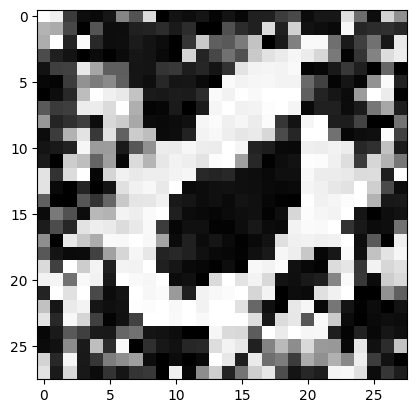

In [9]:
# DO NOT CHANGE

plt.imshow(x.detach().cpu().numpy()[0,0], cmap='gray')

## Improving the Manual Attack With Problem-Specific Knowledge

So we can get recognizable digits, but they're extremely noisy.  We know that this is a digit dataset, so it seems likely that the background should be clean. We can adjust our loss function slightly to penalize the loss by the magnitude of any given pixel to encourage the optimization process to only "spend" loss where it really helps improve the classification.  This is as simple as adding `x.abs().sum()` to our loss function and then multiplying it by some small value -- this value indicates how much we "charge" the optimizer for each pixel as the value moves away from zero.

The tradeoff here is important to get right: too large a price per nonzero pixel, and the optimizer simply decides its not worth it and gives us a black image. To small a price and we don't denoise it.  
:::{admonition} Exercise!

Try some different values for the 'price' (`0.005` in the code below) -- see what happens. See what range gives you good results. Does this change depending on the class you're trying to find.
:::

4.273147106170654
3.2479140758514404
2.470675468444824
1.929605484008789
1.5218393802642822
1.182888388633728
0.9473421573638916
0.8294312953948975
0.7829612493515015
0.762137770652771


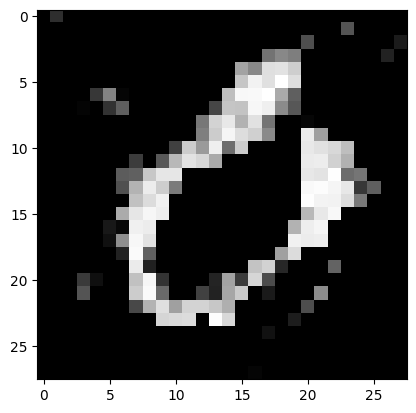

In [10]:
# provided code

x = nn.Parameter(torch.ones(1,1,28,28)*.5)
x_optimizer = torch.optim.Adam([x])

target = torch.tensor([0])


for step in range(1_000):
    yhat = model(x.to(device))
    x_optimizer.zero_grad()
    loss = F.cross_entropy(yhat, target.to(device))
    loss.backward()
    x_optimizer.step()
    x.data = torch.clamp_(x.data, 0, 1)
    if not step%100:print(loss.item())

for step in range(1_000):
    yhat = model(x.to(device))
    x_optimizer.zero_grad()
    loss = F.cross_entropy(yhat, target.to(device)) + x.abs().sum()*0.005 #<<<< Look here! this is all we had to do!
    loss.backward()
    x_optimizer.step()
    x.data = torch.clamp_(x.data, 0, 1)
    if not step%100:print(loss.item())
    
plt.imshow(x.detach().cpu().numpy()[0,0], cmap='gray')

## Using ART

Doing this by hand every time is tedious and risks introducing errors. Fortunately, we can setup ART to perform the MIFace attack on it.

MIFace is an attack which allows us to invert a model that takes in an image and outputs a label. The attack itself is very similar to what we did above: we specify a model and an output and train the input to match that output. But just like training a model, the attack calculates gradients in order to determine how best to modify the input in order to provide the best output. As you may be noticing this also means that the attack requires access to the model's weights and won't work on a black box.

:::{admonition} Exercise!
Since MIFace is similar to how we train models, setting it up requires similar things.
1. Define the loss function to use in inverting our toy model
2. Initialize the `PyTorchClassifier` as the variable `classifier`. You can read about the the parameters needed at https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/estimators/classification.html#pytorch-classifier
3. Initialize the attack, specify a `learning_rate` of 0.1 and `max_iter` of 100
5. When you run it, you should get all ten digits reconstructed.
Randomness does play a role in this step, so feel free to run this step multiple times and if you think you are getting in-accurate results, please ask for help.

```{hint}
Don't forget to define `clip values`, `input shape`, and the `number of classes` when determining what parameters to use in the classifier!
```

```{hint}
The loss function is the same as we used above. This is standard for multi-class classification problems.  

Look at the model printout from when it was loaded; can you tell how many classes it has from that?
```

:::

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

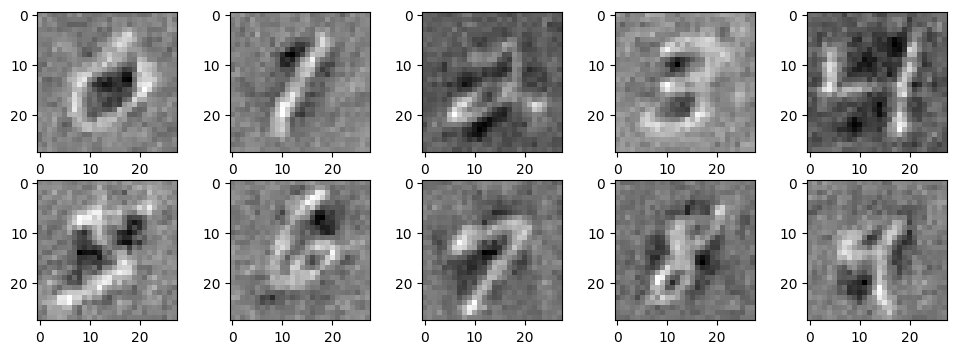

In [18]:
# provided code

classifier = PyTorchClassifier(model=model, 
                               loss= F.cross_entropy,
                               input_shape=(10,1,28,28),
                               nb_classes=10
                              )

y = torch.tensor([0,1,2,3,4,5,6,7,8,9])

attack = MIFace(classifier,
                max_iter = 100,
                learning_rate=0.1
               )

x_train_infer = np.zeros((10,1,28,28)) # YOUR CODE HERE! Make sure your final shape is (10, 1, 28, 28)

x_train_infer = attack.infer(x=x_train_infer, y=y)


# plotting boilerplate
fig = plt.figure(figsize=(12,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train_infer[i,0], cmap='gray')


The solution can be found in the [answer key](answers-1_inversion.ipynb) notebook.

And you can see that we can successfully recover a (noisy) examplar for each class.

## When Inversion Doesn't Work

Now let's look at a more realistic model.  We'll use MobileNet again. Some key differences:
1. MobileNet is much larger (take a peek at it after its loaded)
2. MobileNet has 1000 classes, not 10
3. Where MNIST is trained on individual digits against a black background, so all (e.g.) 8s look pretty similar, MobileNet data within ieach class is much more diverse

:::{admonition} Exercise!
Given the points above, convince yourself before we get rolling that we should expect worse results from such a model...ponder like a Math Professor...
:::

In [19]:
# DO NOT CHANGE

#load the model from the pytorch hub
target_model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.DEFAULT', verbose=False)

# Put model in evaluation mode
target_model.eval()

# put the model on a GPU if available, otherwise CPU
target_model.to(device);

# Define the transforms for preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(224),  # Crop the image to 224x224 about the center
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize the image with the ImageNet dataset mean values
        std=[0.229, 0.224, 0.225]  # Normalize the image with the ImageNet dataset standard deviation values
    )
]);

unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
   std= [1/s for s in [0.229, 0.224, 0.225]]
)

with open("../data/labels.txt", 'r') as f:
    labels = [label.strip() for label in f.readlines()]

:::{admonition} Exercise!

Grab any image from `data/101_ObjectCategories`, preprocess it, get it's label from the model, and display the image along with the label. Then setup ART to perform the MIFace attack on our model.

Set up MIFace for MobileNet.  Fewer hints this time! Double-check the documentation.
- https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/estimators/classification.html#pytorch-classifier
- Use a `learning_rate` of 0.5 and `max_iter` of 500 to start with.
- Don't forget to pre/post-process and `clip_values`

Randomness does play a role in this step, so feel free to run this step multiple times.  See if you can find a good combination of parameters to get something that's at least evocative of your target class.

:::

In [26]:
# provided code

classifier = PyTorchClassifier(model=target_model, 
                               loss= F.cross_entropy,
                               input_shape=(1,3,128,128),
                               nb_classes=1000,
                               clip_values=(0,1)
                              )

y = torch.tensor([971]) # bubble

attack = MIFace(classifier,
                max_iter = 5000,
                learning_rate=0.5,
                threshold=1.
               )

x_train_infer = np.zeros((1,3,128,128))
#x_train_infer[0,0] *= 0
x_adv = attack.infer(x=x_train_infer, y=y)

Model inversion:   0%|          | 0/1 [00:00<?, ?it/s]

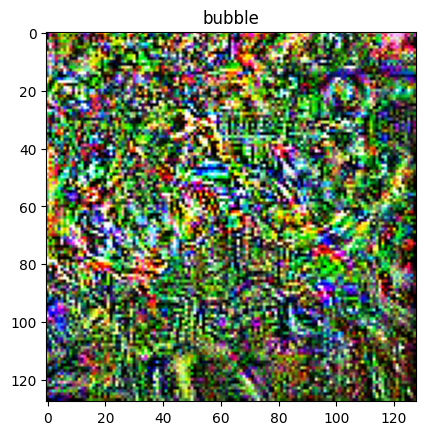

In [28]:
fig = plt.figure()
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 1),  # creates 2x2 grid of axes
             axes_pad=0.3,
                 )

im = x_adv[0]
grid[0].imshow(im.T)
grid[0].set_title(labels[y[0]])
plt.show()

Now that we know the attack sort of works, how do we get better results? Most things will trade accuracy for computational time. The primary variables you will be controlling are:
- learning_rate - how large the changes can be per step
- x - The input that is improved
- max_iter - how many steps to try

Additionally, these variables could cause the attack to end early, sometimes when you don't want it to.
- window_length - how long to keep trying before giving up
- threshold - when to consider the solution "done"


:::{admonition} Exercise!
1. Adjust the value that you start with for `x` to visually improve the results.
2. once results are getting better, adjust the `learning_rate` down, this will likely remove detail but when we adjust `max_iter` higher, it should help.
3. adjust `max_iter` toward 1000. In a real attack you probably want to go closer to `100,000`, however that will take considerably longer to compute (~30 minutes with a GPU) 
:::


In [31]:
# your code here
classifier = PyTorchClassifier(model=target_model, 
                               loss= F.cross_entropy,
                               input_shape=(1,3,128,128),
                               nb_classes=1000,
                               clip_values=(0,1)
                              )

y = torch.tensor([971]) # bubble

attack = MIFace(classifier,
                max_iter = 5000,
                learning_rate=0.01,
                threshold=1.
               )

x_train_infer = np.ones((1, 3, 128, 128)) * 0.5
#x_train_infer[0,0] *= 0
x_adv = attack.infer(x=x_train_infer, y=y)

Model inversion:   0%|          | 0/1 [00:00<?, ?it/s]

From here it's mostly trial and error until you find settings you like, and decide if you want to target every classification or just a specific few.

:::{admonition} Exercise!
Pick some other classifications and target them. Start with a small `max_iter` and large `learning_rate`, then adjust them to more reasonable values.
:::


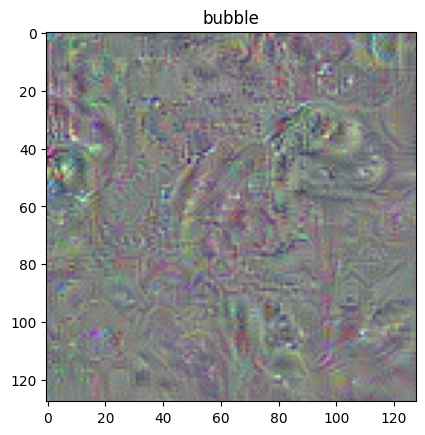

In [32]:
# your code here
fig = plt.figure()
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 1),  # creates 2x2 grid of axes
             axes_pad=0.3,
                 )

im = x_adv[0]
grid[0].imshow(im.T)
grid[0].set_title(labels[y[0]])
plt.show()

# Membership Inference
If you come from a security background, it may be easiest to view inference as a cross between fuzzing and cryptography that actually is easier than either on their own. Our goal will be to infer something we shouldn't know from an ML application. Normally this is the model itself, however the application it's used in determines the constraints and impacts. We will cover two of the three forms of inference. Black box inference, also referred to as blind inference, is typically involving a model hosted on a web page, and all you can do is provide input, and receive output from it. Grey box inference involves a model you don't have the training data for, but you do have access to the model itself. This could be a client side application, a model pilfered from a target, or an application with other vulnerabilities. We won't be covering White box entirely, because that implies there is nothing to infer, and everything is already known.

## Blind Inference

Inference is often considered in the context of training data. Where the attack is inferring what training data was used to create a model. This comes in one of two forms. Reproducing the original training data, or inferring if a given piece of data is a member of the training set. In this first part we will be focused on reproducing training data used as is covered in the recent example of ["Extracting Training Data from Diffusion Models"](https://arxiv.org/abs/2301.13188). So first we will load the model they used in that paper.

The first step in real life would be generating 500 images, from every prompt however we have access to their paper, so we don't have to do quite as much work.

:::{admonition} Exercise!

- Review the paper, ["Extracting Training Data from Diffusion Models"](https://arxiv.org/abs/2301.13188) and look for the information needed to finish the code bellow.
- Run it and see if you get results that match those of the paper.
- `i` is the seed to allow us all to get the same results


```{hint} prompt

- The prompt is on the first page...
```


:::

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

C:\Users\Usuario\Anaconda3\envs\redai\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Usuario\.cache\huggingface\hub\models--compvis--stable-diffusion-v1-1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/926 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\Usuario\.cache\huggingface\hub\models--compvis--stable-diffusion-v1-1\snapshots\574555a657f0c8d6e970a02c7e095e9d4220dcbf\vae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\Usuario\.cache\huggingface\hub\models--compvis--stable-diffusion-v1-1\snapshots\574555a657f0c8d6e970a02c7e095e9d4220dcbf\vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch C:\Users\Usuario\.cache\huggingface\hub\models--compvis--stable-diffusion-v1-1\snapshots\574555a657f0c8d6e970a02c7e095e9d4220dcbf\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\Usuario\.cache\huggingface\hub\models--compvis--stable-diffusion-v1-1\snapshots\574555a657f0c8d6e970a02c7e095e9d4220dcbf\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Usuario\Anaconda3\envs\redai\Lib\site-packages\diffusers\models\attention_processor.py:3286: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
C:\Users\Usuario\Anaconda3\envs\redai\Lib\site-packages\diffusers\image_processor.py:769: FutureWarning: the output_type np.array is outdated and has been set to `np`. Please make sure to set it to one of these instead: `pil`, `np`, `pt`, `latent`
  deprecate("Unsupported output_type", "1.0.0", deprecation_message, standard_warn=False)


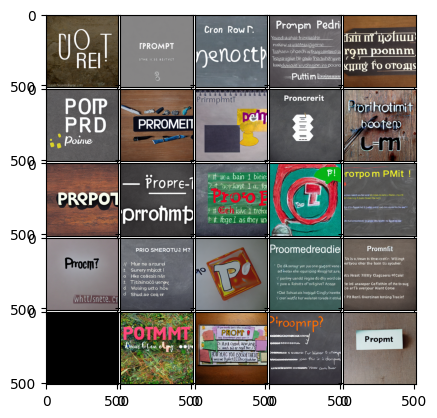

In [33]:
# provided code
pipe = StableDiffusionPipeline.from_pretrained("compvis/stable-diffusion-v1-1", torch_dtype=torch.float16)
pipe = pipe.to(device)

prompt = "PROMPT" # TODO: choose a prompt!

i = 716907
torch.manual_seed(i)
imagesnp = pipe(prompt, num_images_per_prompt=25, output_type="np.array").images
images = pipe.numpy_to_pil(imagesnp)

fig = plt.figure()
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 )

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()


Blind inference of this sort relies on the fact that an overfit training image will be strongly favored by the diffusion model and as such, multiple random seeds will settle onto the same pixel arrangement. As such, in this example it may be possible to visually identify the training image. With 500 images and a target that isn't as strongly favored, this may not be realistic however. So we can programmatically compare each image and look for ones that have a mean squared error less than a set value.

:::{admonition} Exercise!

1. Rewrite the for loop to only show images that have an `MSELoss` less than a given value.
2. adjust that value to only show the images which are visually similar (L2 maybe?).

:::

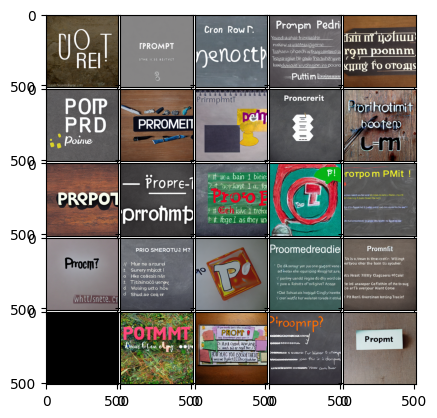

In [34]:
# provided code

lossfn = torch.nn.MSELoss()

imagest = torch.Tensor(imagesnp)
fig = plt.figure()
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 )
for i in range(len(imagest)):
    grid[i].imshow(images[i])

plt.show()

The solution to this can be found in the [answer key](answers-1_inversion.ipynb) notebook.

:::{admonition} Exercise!

1. Change the prompt to "a gray sky" and observe how similar the images are.
2. Read section "4.2.1 Extraction Methodology" from ["Extracting Training Data from Diffusion Models"](https://arxiv.org/abs/2301.13188) and implement the solution they describe that doesn't involve finding clique size.
:::

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


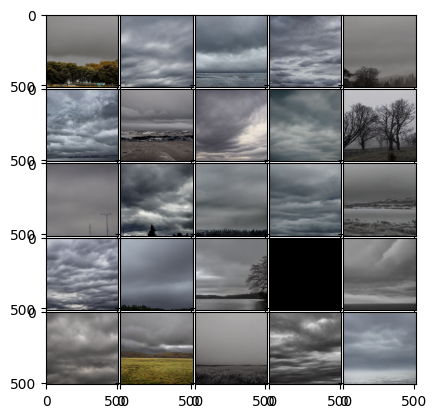

In [35]:
# DO NOT CHANGE

prompt = "A gray sky"
i = 716907
torch.manual_seed(i)
imagesnp = pipe(prompt, num_images_per_prompt=25, output_type="np.array").images
images = pipe.numpy_to_pil(imagesnp)
imagest = torch.Tensor(imagesnp)
fig = plt.figure()
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 )

for ax, im in zip(grid, images):
    # this part needs to be re-written
    ax.imshow(im)

plt.show()

# Conclusion

Okay - this lab wasn't entirely fair, but we've covered `MSE` and `L2` distances several times! We also showed you how to perform basic inversion attacks and improve them, how more sophisticated attacks are implemented in AIRT and how even those can struggle with realistic models, and finally an inversion attack against a more complex diffusion model.

Even though this lab is less wordy and offers less direction, _everything_ you did here is a concept you covered in the earlier labs. Which were much more verbose. We also hope you've started to appreciate all the little code snippets and the fact we've installed several hefty libraries in a tidy package. This attack is probably most relevant against facial recognition models, but running it against internal models is likely valuable as well - especially if they've been trained on other types of PII. We'll cover this type of attack again in the LLM labs. Here, we mostly want to see how much you remembered from the first lab while also introducing you to another base primitive. 

## What You Learned

1. How to perform a basic inversion attack by finding an input that maximizes a particular output.
2. How to build a custom loss function that uses domain specific knowledge to improve the simple inversion attack.
3. How to use AIRT tools to automate inversion attacks against models.
4. Attack a more realistic model and see where the basic attacks begin to fail, and how to explore parameterization of the attack to improve it.
5. An example of extracting data from diffusion models.

**Move on to the [Poisoning Module](../6_poisoning/1_poisoning.ipynb).**

![DLI Logo](../assets/DLI_Header.png)